#Library

In [ ]:
!pip install -q torchdiffeq

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [ ]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

#Dataset

In [ ]:
energy_file_name = ''
df = pd.read_excel(energy_file_name)

In [ ]:
df = df.iloc[4000:6000,:]

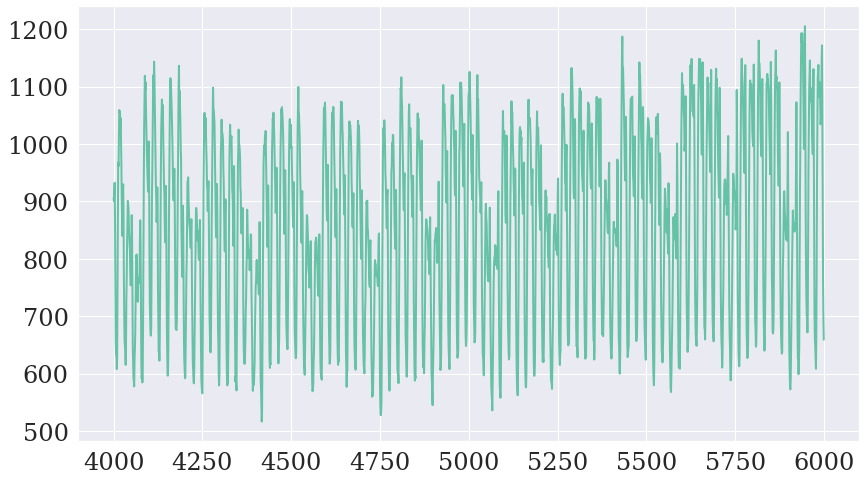

In [ ]:
plt.plot(df['ConsumprionMWtH'])

In [ ]:
n_points = 10
time_shifts = [i for i in range(1,n_points+1)][::-1]

df_emb = df.iloc[:, 3:4]
df_emb.columns = ['energy']

for shift in time_shifts:
    df_emb[f'energy-{shift}h'] = df_emb.iloc[:, 0].shift(shift)

df_emb.dropna(inplace=True)
X_energy = df_emb.iloc[:, 1:].values


In [ ]:
from sklearn.model_selection import train_test_split


train_ratio = 0.74

X_train, X_test = train_test_split(
    X_energy,

    train_size=train_ratio,
    shuffle=False
)

print('Train size =', X_train.shape[0])
print('Test size =', X_test.shape[0])

Train size = 1472
Test size = 518


In [ ]:
from sklearn.preprocessing import StandardScaler


energy_scaler = StandardScaler()


X_train_norm = energy_scaler.fit_transform(X_train)
X_test_norm = energy_scaler.transform(X_test)

In [ ]:
class EnergyAndTimeDataset(Dataset):
    def __init__(self, energy_data: np.ndarray, ts: np.ndarray, seq_len = 20):
        assert len(energy_data) == len(ts)
        
        self.energy = torch.from_numpy(energy_data).float()
        self.time = torch.from_numpy(ts).float()
        self.seq_len = seq_len
    def __len__(self):
        return len(self.energy)
    
    def __getitem__(self, index: int):
        if index >= len(self):
            raise IndexError(f'{self.__class__.__name__} index out of range')
        index = min(index, len(self) - self.seq_len)
        return self.energy[index:index+self.seq_len], self.time[index:index+self.seq_len, 0]


In [ ]:
def build_time_emb(time_shifts: list, start: int, size: int, denom: int = 1000):
    ts = np.arange(start, start+size).reshape(-1, 1)
    ts = np.broadcast_to(ts, (ts.size, len(time_shifts)))
    
    time_shifts = np.array(time_shifts).reshape(1, -1)
    return (ts - time_shifts) / denom



time_shifts = [i for i in range(1,n_points+1)][::-1]
train_ts = build_time_emb(time_shifts, df_emb.index[0], X_train_norm.shape[0])
test_ts = build_time_emb(
    time_shifts,
    df_emb.index[0]+X_train_norm.shape[0],
    X_test_norm.shape[0]
)




#NODE Model

In [ ]:
from torchdiffeq import odeint
from typing import Optional


class ODEFunc(nn.Module):
    def __init__(self, ode_func_net, time_inv = True):
        """
        ode_func_net: neural net that used to transform hidden state in ode
        """
        super(ODEFunc, self).__init__()
        self.gradient_net = ode_func_net
        self.time_inv = time_inv
    def forward(self, t_local, y, backwards = False):
        """
        Perform one step in solving ODE. Given current data point y and
        current time point t_local, returns gradient dy/dt at this time point
        t_local: current time point
        y: value at the current time point
        """
        grad = self.get_ode_gradient_nn(t_local, y)
        if backwards:
            grad = -grad
        return grad

    def get_ode_gradient_nn(self, t_local, y):
        if self.time_inv:
          return self.gradient_net(y)
        else:        
          return self.gradient_net(torch.stack( (t_local,y)))

    def sample_next_point_from_prior(self, t_local, y):
        """
        t_local: current time point
        y: value at the current time point
        """
        return self.get_ode_gradient_nn(t_local, y)




In [ ]:
def train_ode(ode_func, dataloader, loss_fn, optimizer, train_history=None, test_history=None):
    
    epoch_loss = 0
    history = []
    
    for i, (energy, ts) in enumerate(dataloader):
        optimizer.zero_grad()
        batch_size, seq_len = energy.shape[0],energy.shape[1]
        energy = energy.to(device)
        ts = ts.to(device)
        out = torch.zeros_like(energy).to(device)
        for j in range(energy.shape[0]):
           out[j,:,:] = odeint(ode_func, energy[j,0,:], ts[j,:], rtol=1e-03, atol=1e-05)

        loss = loss_fn(out, energy)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

            clear_output(True)
            ax[0].plot(history)
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history)
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('General train history')
            if test_history is not None:
                ax[2].plot(test_history)
                ax[2].set_xlabel('Epoch')
                ax[2].set_title('General test history')
                
            plt.show()
            
    return epoch_loss / len(dataloader)

In [ ]:
def test_ode(ode_func, dataloader, loss_fn):
    ode_func.eval()
    
    epoch_loss = 0
    
    for energy, ts in dataloader:
        energy = energy.to(device)
        batch_size = energy.shape[0]
        ts = ts.to(device)
        out =  torch.zeros_like(energy).to(device) 
            
        with torch.no_grad():
            for j in range(energy.shape[0]):
                out[j,:,:] = odeint(ode_func, energy[j,0,:], ts[j,:], rtol=1e-03, atol=1e-05)
            loss = loss_fn(out, energy)
        

        epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

#NODE Experiment

##init

In [ ]:
latent_dim = 50
seq_len = 25
ode_func = ODEFunc(nn.Sequential(
    nn.Linear(n_points, latent_dim),
    nn.ReLU(),
    nn.Linear(latent_dim, n_points)
), time_inv = True)

device = torch.device('cuda')
ode_func.to(device)
print('Число параметров:', sum(p.numel() for p in ode_func.parameters() if p.requires_grad))

Число параметров: 1060


In [ ]:
seq_len = 25
train_dataset = EnergyAndTimeDataset(X_train_norm, train_ts,seq_len  = seq_len)
test_dataset = EnergyAndTimeDataset(X_test_norm, test_ts, seq_len = seq_len)

##training

In [ ]:
batch_size = 64
tr_dataloader = DataLoader(train_dataset, batch_size, drop_last=True, shuffle = True)
tst_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = Adam(ode_func.parameters(), lr=1e-2)

In [ ]:
epochs = 50
train_history = []
test_history = []

In [ ]:
%%time
from tqdm.notebook import tqdm

save_link = ''


for epoch in tqdm(range(epochs)):
    print(f'epoch {epoch}')
    
    train_loss = train_ode(ode_func, tr_dataloader, loss_fn, optimizer, train_history, test_history)
    test_loss = test_ode(ode_func, tst_dataloader, loss_fn)
    train_history.append(train_loss)
    test_history.append(test_loss)
    torch.save(ode_func,save_link)
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')

##prediction

In [ ]:
best_model_file = ''
best_ode_func = torch.load( best_model_file).to(device)

In [ ]:
t_pred = test_ts[:200,0]
X_pred = X_test_norm[:200,0]

In [ ]:
preds = []
for i in [1,5,10,20,25]:
    ts = np.array(list(train_ts[-i:,0]) + list(t_pred))
    t_pred_tensor = torch.from_numpy(ts).float().to(device)
    x_0 = torch.unsqueeze(torch.from_numpy(X_train_norm[-i,:]).float().squeeze(), 0).to(device).squeeze()
    pred = odeint(best_ode_func, x_0, t_pred_tensor, rtol=1e-03, atol=1e-05)[-200:,0].cpu().detach().numpy()
    preds.append(pred)
preds = np.array(preds)

min_pred = np.apply_along_axis(min,  0, preds)
max_pred = np.apply_along_axis(max,  0, preds)
avr_pred = np.apply_along_axis(np.mean,  0, preds)

Text(0, 0.5, 'Consumption')

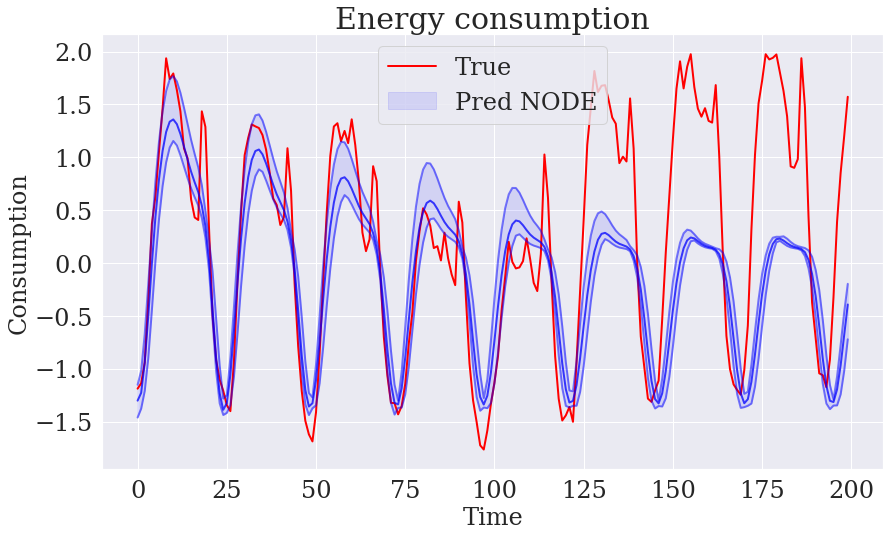

In [ ]:

plt.plot(X_pred, label = 'True', c ='r')

plt.plot(min_pred, c = 'b', alpha = 0.5)
plt.plot(max_pred, c = 'b', alpha = 0.5)
plt.plot(avr_pred, c = 'b', alpha = 0.75)
plt.fill_between(range(0,200), max_pred, min_pred, alpha = 0.1, color = 'b', label = 'Pred NODE',interpolate=True)
plt.title('Energy consumption')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Consumption')

In [ ]:
print(f'Prediction NODE MSE error: {np.mean((avr_pred - X_pred)**2)}')

Prediction NODE MSE error: 0.6613033059631657


Text(0, 0.5, 'MSE Error')

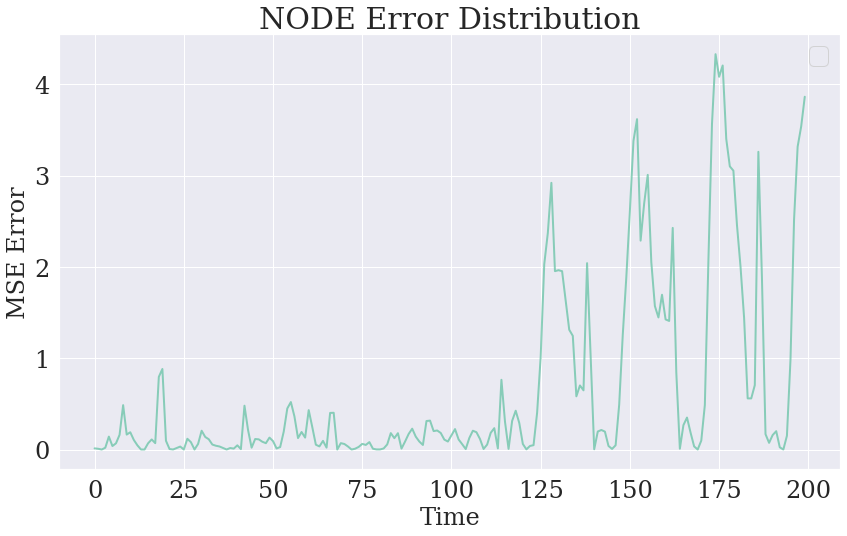

In [ ]:
error  = (avr_pred - X_pred)**2
plt.plot(error, alpha = 0.75)

plt.title('NODE Error Distribution')

plt.legend()
plt.xlabel('Time')
plt.ylabel('MSE Error')

#VAE model

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        t = t[:,None]
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[ :self.latent_dim]
        z0_log_var = z0[ self.latent_dim:]
        return z0_mean, z0_log_var

class NeuralODEDecoder(nn.Module):
    def __init__(self, func, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.func  = func
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = odeint(self.func, z0, t , rtol=1e-03, atol=1e-05)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs
class ODEVAE(nn.Module):
    def __init__(self, func, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(func, output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p

In [ ]:
def train_vae(vae, dataloader, optimizer, noise_std = 0.01, train_history=None):
   history = []
   epoch_loss = 0
   for i, (x, t) in enumerate(dataloader):
        optimizer.zero_grad()
        total_loss = 0
        x, t = x.to(device),t.to(device)
        seq_len = x.shape[1]
        
        for j in range(x.shape[0]):
            max_len = np.random.choice([seq_len, seq_len//2, seq_len//3])

            x_p, z, z_mean, z_log_var = vae(x[j,:max_len,:], t[j,:max_len])
            z_var = torch.exp(z_log_var)
            kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - z_var, -1)

            loss = 0.5 * (torch.pow((x[j,:max_len,:]-x_p),2)).sum(-1).sum(0) / noise_std**2 + kl_loss
            loss = torch.mean(loss)
            loss /= max_len
            total_loss += loss
        total_loss /= x.shape[0]
        total_loss.backward()
        history.append(total_loss.item())
        epoch_loss += total_loss.item()
        optimizer.step()
        if (i + 1) % 5 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

            clear_output(True)
            ax[0].plot(history)
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history)
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('General train history')

                
            plt.show()
            
   return epoch_loss / len(dataloader)

#VAE Experiment

##init

In [ ]:
latent_dim = 6
seq_len = 25
ode_func = ODEFunc(nn.Sequential(
    nn.Linear(latent_dim, 64),
    nn.ReLU(),
    nn.Linear(64, latent_dim)
), time_inv = True)

device = torch.device('cuda')
ode_func.to(device)


ODEFunc(
  (gradient_net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [ ]:
vae = ODEVAE(ode_func, output_dim= n_points,hidden_dim = 64, latent_dim = latent_dim ).to(device)

In [ ]:
print('Число параметров:', sum(p.numel() for p in vae.parameters() if p.requires_grad))

Число параметров: 17500


In [ ]:
seq_len = 50
train_dataset = EnergyAndTimeDataset(X_train_norm, train_ts,seq_len  = seq_len)
test_dataset = EnergyAndTimeDataset(X_test_norm, test_ts, seq_len = seq_len)

##training

In [ ]:
batch_size = 64
tr_dataloader = DataLoader(train_dataset, batch_size, drop_last=True, shuffle = True)
tst_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

In [ ]:
train_history = []

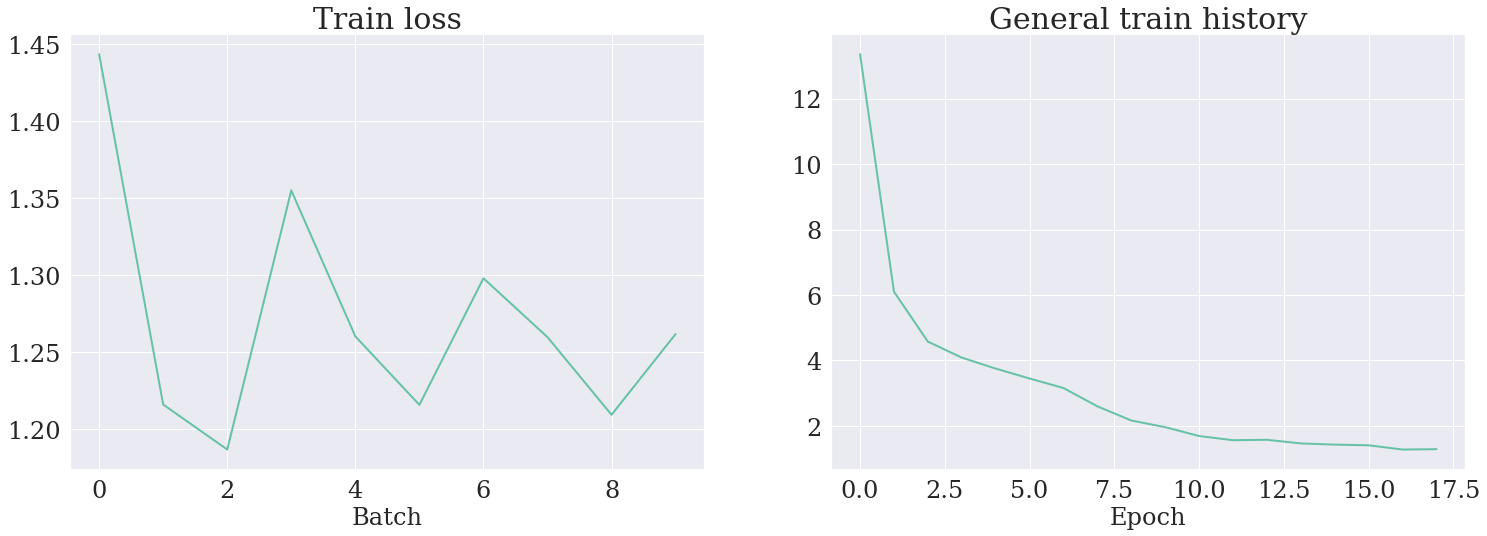

In [ ]:
%%time
from tqdm.notebook import tqdm

epochs = 50
vae_save_link = ''
for epoch in tqdm(range(epochs)):
    print(f'epoch {epoch}')
    
    train_loss = train_vae(vae,  tr_dataloader,  optimizer, 1, train_history)
    train_history.append(train_loss)
    torch.save(vae, vae_save_link)

    print(f'Train Loss: {train_loss:.3f}')


##prediction

In [ ]:
best_vae_file = ''
best_vae = torch.load(best_vae_file).to(device)

In [ ]:
t_pred = test_ts[:200,0]
X_pred = X_test_norm[:200,0]

In [ ]:
preds_vae = []
for i in [2,5,10,20,25]:
    ts = np.array(list(train_ts[-i:,0]) + list(t_pred))
    t_pred_tensor = torch.from_numpy(ts).float().to(device)
    x_0 = torch.unsqueeze(torch.from_numpy(X_train_norm[-i:,:]).float().squeeze(), 0).to(device).squeeze()
    pred_vae = best_vae.generate_with_seed(x_0, t_pred_tensor).cpu().detach().numpy()[i:,0]
    preds_vae.append(pred_vae)
preds_vae = np.array(preds_vae)

min_pred_vae = np.apply_along_axis(min,  0, preds_vae)
max_pred_vae = np.apply_along_axis(max,  0, preds_vae)
avr_pred_vae = np.apply_along_axis(np.mean,  0, preds_vae)

Text(0, 0.5, 'Consumption')

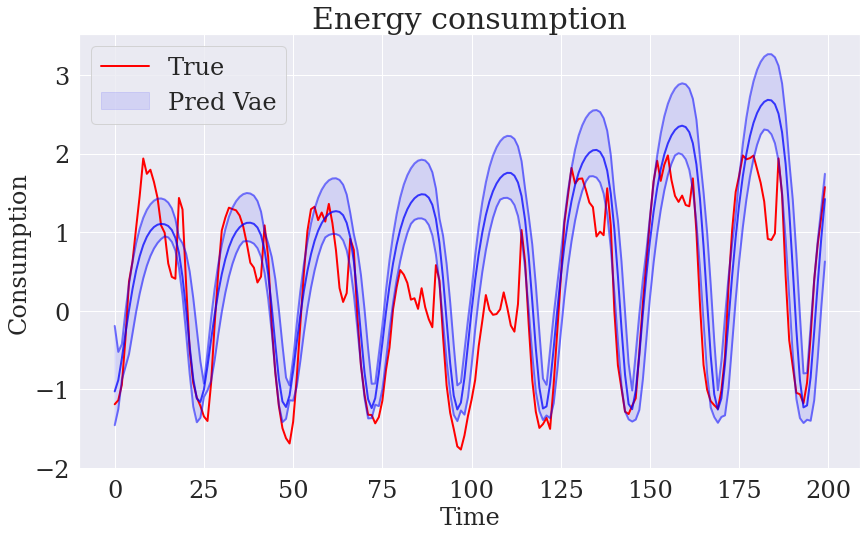

In [ ]:

plt.plot(X_pred, label = 'True', c ='r')

plt.plot(min_pred_vae, c = 'b', alpha = 0.5)
plt.plot(max_pred_vae, c = 'b', alpha = 0.5)
plt.plot(avr_pred_vae, c = 'b', alpha = 0.75)
plt.fill_between(range(0,200), max_pred_vae, min_pred_vae, alpha = 0.1, color = 'b', label = 'Pred Vae',interpolate=True)
plt.title('Energy consumption')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Consumption')

In [ ]:
print(f'Prediction VAE MSE error: {np.mean((avr_pred_vae - X_pred)**2)}')

Prediction VAE MSE error: 0.5813994808881864


Text(0, 0.5, 'MSE Error')

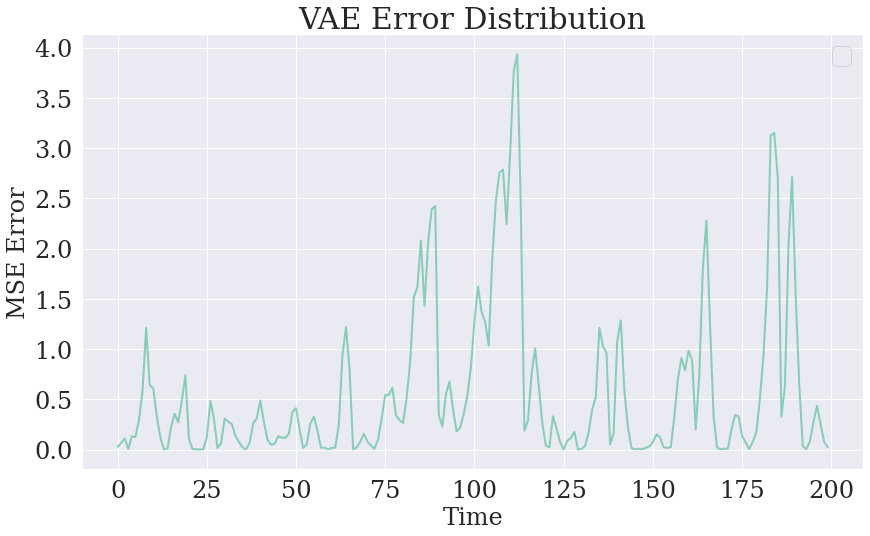

In [ ]:
error  = (avr_pred_vae - X_pred)**2
plt.plot(error, alpha = 0.75)

plt.title('VAE Error Distribution')

plt.legend()
plt.xlabel('Time')
plt.ylabel('MSE Error')

## generation

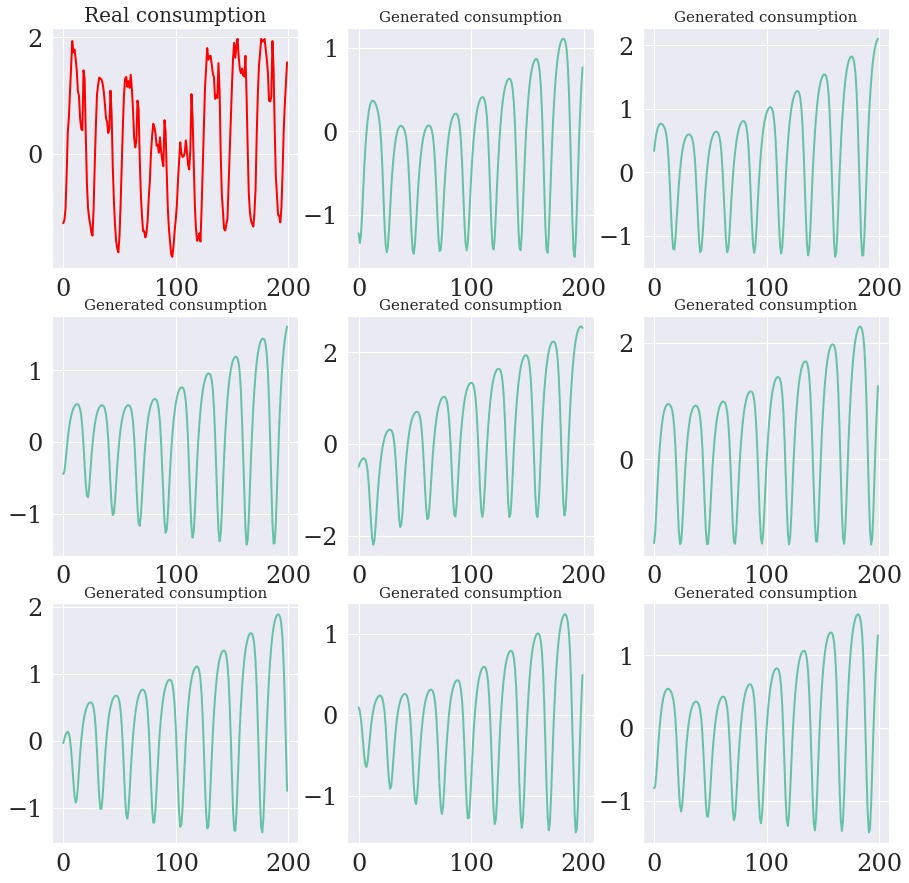

In [ ]:
n_samples = 9
plt.figure(figsize = (15,15))
plt.subplot(3, 3, 1)
plt.plot(X_pred, label = 'True', c ='r')

plt.title('Real consumption', size  = 20)


for i in range(2,n_samples +1):
    plt.subplot(3, 3, i)
    z_0 = torch.normal(torch.zeros(latent_dim), torch.ones(latent_dim)).to(device)

    t_pred_tensor = torch.from_numpy(t_pred).float().to(device)
    gen_vae = best_vae.decoder(z_0, t_pred_tensor).cpu().detach().numpy()[:,0]


    plt.plot(gen_vae, label = 'gen')
    plt.title('Generated consumption', size  = 15)
